## Interconnections on EESREP

This file aims at developping a custom component acting like an interconnection between two zones

### Imports

In [2]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from eesrep import Eesrep
from eesrep.components.generic_component import GenericComponent
from eesrep.components.converter import Cluster
from eesrep.components.sink_source import FatalSink, Source, Sink
from eesrep.eesrep_enum import TimeSerieType
from eesrep.solver_interface.generic_interface import GenericInterface

### Simulation parameters

In [8]:
global_time_step = 1                                                                        # Time step size (hours)
global_time_shift = 50                                                                      # Shift between the beginning of two sucessing horizon (time steps)
global_future_size = 100                                                                    # Duration of each horizon (time steps)
global_horizon_count = 40                                                                   # Number of horizons to solve (horizon)

max_load = 2000.            # MWh
min_load = 0.               # MWh
load_period = 24            # h
load_amplitude = 0.2        # 20 % of max_load

global_step_count = (global_horizon_count - 1) * global_time_shift + global_future_size     # Calculates the total number of time steps
#print("Nombre de pas de simulation :", global_step_count)                                  # Prints the previous value if needed

# True activates the spilled energy virtual sink and demand-side management virtual source
global_bool_virtual_balancing = True
global_load_type = "linear"
global_load_typeB = "null"
# 1/2/12 activates one/one/two perturbation(s) on load to be set in user-defined inputs section
global_load_perturbation = 0


## Model definition

### Custom components definition

In [4]:
class Interco(GenericComponent):
    """EESREP interconnection model"""

    def __init__(self, 
                 name:str,
                 efficiency:float,
                 p_max:float,
                 p_min_rel:float,
                 opex:float,
                 turn_on_price:float,
                 ramp_up:float,
                 ramp_down:float,
                 some_ts:pd.DataFrame = pd.DataFrame()):
        
        self.name = name
        self.efficiency = efficiency
        self.p_max = p_max
        self.p_min_off = 0
        self.p_min_on = p_min_rel * p_max
        self.opex = opex
        self.turn_on_price = turn_on_price
        self.ramp_up = ramp_up
        self.ramp_down = ramp_down

        #   Necessary object, instanciate empty if not used
        self.time_series = {
            # "some_time_serie":{
            #     "type":TimeSerieType.INTENSIVE,
            #     "value":some_ts
            # } 
        }

        self.boolstate_AB = "boolstate_AB"
        self.boolstate_BA = "boolstate_BA"
        self.boolstate_0 = "boolstate_0"
        self.electricity_inA = "electricity_inA"
        self.electricity_outA = "electricity_outA"
        self.electricity_inB = "electricity_inB"
        self.electricity_outB = "electricity_outB"

    def io_from_parameters(self) -> dict:
        """Lists the component Input/Output.
        """
        return {
                    "boolstate_AB":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "boolstate_BA":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "boolstate_0":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "electricity_inA":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "electricity_outA":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "electricity_inB":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "electricity_outB":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                }
                }
    
    def build_model(self,
        component_name:str,
        time_steps:list,
        time_series:pd.DataFrame,
        history:pd.DataFrame,
        model_interface:GenericInterface):
        """Builds the model at the current horizon.

        Parameters
        ----------
        component_name : str
            Component name to index the MILP variables
        time_steps : list
            List of the time steps length 
        time_series : pd.DataFrame
            Dataframe containing the time series values at the current horizon time steps.
        history : pd.DataFrame
            Dataframe with the variables of previous iterations if "continuity" is at true.
        model_interface : GenericInterface
            Solver interface used to provide the variables

        """

        variables = {}

        if True:
            variables["boolstate_AB"] = model_interface.get_new_discrete_variable_list(component_name+"_boolstate_AB_", len(time_steps), 0, 1)
            variables["boolstate_BA"] = model_interface.get_new_discrete_variable_list(component_name+"_boolstate_BA_", len(time_steps), 0, 1)
            variables["boolstate_0"] = model_interface.get_new_discrete_variable_list(component_name+"_boolstate_0_", len(time_steps), 0, 1)

            variables["electricity_inA"] = model_interface.get_new_continuous_variable_list(component_name+"_electricity_inA_", len(time_steps), self.p_min_off, self.p_max)
            variables["electricity_outA"] = model_interface.get_new_continuous_variable_list(component_name+"_electricity_outA_", len(time_steps), self.p_min_off, self.p_max)
            variables["electricity_inB"] = model_interface.get_new_continuous_variable_list(component_name+"_electricity_inB_", len(time_steps), self.p_min_off, self.p_max)
            variables["electricity_outB"] = model_interface.get_new_continuous_variable_list(component_name+"_electricity_outB_", len(time_steps), self.p_min_off, self.p_max)
        # end if True to collapse variable declaration

        ###################################################################################################
        ###################################################################################################
        ###################################################################################################
        ######################### Instantiation of constraints at each time_step ##########################
        ###################################################################################################
        ###################################################################################################
        ###################################################################################################
        for i in range(len(time_steps)):
            if True:
                # Intermediate assignement of the current step
                current_step_elec_inA = variables["electricity_inA"][i]
                current_step_elec_outA = variables["electricity_outA"][i]
                current_step_elec_inB = variables["electricity_inB"][i]
                current_step_elec_outB = variables["electricity_outB"][i]

                current_step_boolstate_AB = variables["boolstate_AB"][i]
                current_step_boolstate_BA = variables["boolstate_BA"][i]
                current_step_boolstate_0 = variables["boolstate_0"][i]

                # Intermediate assignement of the previous step
                if i == 0:
                    # First step of the current horizon : the previous step may not exist and might be fetched in the history
                    if len(history) == 0:
                        # First time step of the first horizon
                        previous_step_elec_inA = 0
                        previous_step_elec_outA = 0
                        previous_step_elec_inB = 0
                        previous_step_elec_outB = 0

                        previous_step_boolstate_AB = 0
                        previous_step_boolstate_BA = 0
                        previous_step_boolstate_0 = 1
                    else:
                        # First time step of a generic horizon
                        previous_step_elec_inA = history.loc[len(history)-1,"electricity_inA"]
                        previous_step_elec_outA = history.loc[len(history)-1,"electricity_outA"]
                        previous_step_elec_inB = history.loc[len(history)-1,"electricity_inB"]
                        previous_step_elec_outB = history.loc[len(history)-1,"electricity_outB"]

                        previous_step_boolstate_AB = history.loc[len(history)-1,"boolstate_AB"]
                        previous_step_boolstate_BA = history.loc[len(history)-1,"boolstate_BA"]
                        previous_step_boolstate_0 = history.loc[len(history)-1,"boolstate_0"]

                else:
                    # Generic time step of a generic horizon
                    previous_step_elec_inA = variables["electricity_inA"][i-1]
                    previous_step_elec_outA = variables["electricity_outA"][i-1]
                    previous_step_elec_inB = variables["electricity_inB"][i-1]
                    previous_step_elec_outB = variables["electricity_outB"][i-1]

                    previous_step_boolstate_AB = variables["boolstate_AB"][i-1]
                    previous_step_boolstate_BA = variables["boolstate_BA"][i-1]
                    previous_step_boolstate_0 = variables["boolstate_0"][i-1]
                # end if
            # end if True to collapse intermediate assignment of current_step and previous_step variables, and crédit K coefficients if enabled

            if True:
                # Static constraint of imperfect transformation of inputs into outputs
                model_interface.add_equality(left_term = current_step_elec_inA * self.efficiency, 
                                            right_term = current_step_elec_outB)

                model_interface.add_equality(left_term = current_step_elec_inB * self.efficiency, 
                                            right_term = current_step_elec_outA)

                # Mutual exclusivity of states
                model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                    current_step_boolstate_AB,
                                                                    current_step_boolstate_BA,
                                                                    current_step_boolstate_0
                                                                ]),
                                            right_term = 1)
            # end if True to collapse fundamental rules on state, input/output and jepp counting
            
            if True:
                # Static constraints of limited output range while running
                model_interface.add_lower_than(left_term = variables["electricity_inA"][i], 
                                            right_term = model_interface.sum_variables([
                                                                    0 * current_step_boolstate_BA,
                                                                    0 * current_step_boolstate_0,
                                                                    self.p_max * current_step_boolstate_AB
                                                                ])
                                                            )

                # Minimum power constraint with p_min varying at each time step
                model_interface.add_greater_than(left_term = variables["electricity_inA"][i], 
                                                right_term = model_interface.sum_variables([
                                                                    0 * current_step_boolstate_BA,
                                                                    0 * current_step_boolstate_0,
                                                                    0 * current_step_boolstate_AB
                                                                ])
                                                            )

                # Static constraints of limited output range while running
                model_interface.add_lower_than(left_term = variables["electricity_inB"][i], 
                                            right_term = model_interface.sum_variables([
                                                                    0 * current_step_boolstate_AB,
                                                                    0 * current_step_boolstate_0,
                                                                    self.p_max * current_step_boolstate_BA
                                                                ])
                                                            )

                # Minimum power constraint with p_min varying at each time step
                model_interface.add_greater_than(left_term = variables["electricity_inB"][i], 
                                                right_term = model_interface.sum_variables([
                                                                    0 * current_step_boolstate_AB,
                                                                    0 * current_step_boolstate_0,
                                                                    0 * current_step_boolstate_BA
                                                                ])
                                                            )
            # end if True to collapse output level jig according to state
        # end for
        
        

        objective = model_interface.sum_variables([val * self.opex for val in variables["electricity_outA"]] + [val * self.opex for val in variables["electricity_outB"]])
        
        return variables, objective

### User-defined inputs

#### Load

In [11]:

if global_load_type == "linear":
    perturb1_start = 250        # h
    perturb1_end = 500          # h
    perturb1_level = 15.        # MWh

    perturb2_start = 750        # h
    perturb2_end = 980          # h
    perturb2_level = 0.        # MWh


    if global_load_perturbation == 12 and perturb1_end <= perturb2_start:
        ### Generating a linear load ranging from min_load to max_load with two low load perturbations between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb1_start) + (i>perturb1_end))*((i<perturb2_start) + (i>perturb2_end)) + perturb1_level*((i>=perturb1_start)*(i<=perturb1_end))/2 + perturb2_level*((i>=perturb2_start)*(i<=perturb2_end))/2 for i in range(global_step_count + 1)]})
    elif global_load_perturbation == 1:
        ### Generating a linear load ranging from min_load to max_load with a low load perturbation between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb1_start) + (i>perturb1_end)) + perturb1_level*((i>=perturb1_start)*(i<=perturb1_end))/2 for i in range(global_step_count + 1)]})
    elif global_load_perturbation == 2:
        ### Generating a linear load ranging from min_load to max_load with a low load perturbation between user-defined clues
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count)*((i<perturb2_start) + (i>perturb2_end)) + perturb2_level*((i>=perturb2_start)*(i<=perturb2_end))/2 for i in range(global_step_count + 1)]})
    else:
        ### Generating a linear load ranging from min_load to max_load
        fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(min_load + i*(max_load - min_load)/global_step_count) for i in range(global_step_count + 1)]})
    # end if

elif global_load_type == "sin":
    average_load = (min_load + max_load) / 2
    load_pulse = 2 * np.pi / load_period

    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(average_load * (1 - load_amplitude * np.sin(load_pulse * i))) for i in range(global_step_count + 1)]})
    

elif global_load_type == "duck":
    average_load = (min_load + max_load) / 2
    load_pulse = 2 * np.pi / load_period

    fs_df = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [(average_load * (1 - load_amplitude * (np.sin(load_pulse * i) + 2 * (np.sin(2*load_pulse * i)) * ((i%24 <=18)*(i%24 >=12))))) for i in range(global_step_count + 1)]})
# end if 

if global_load_typeB == "null":
    fs_dfB = pd.DataFrame({"time": list(range(global_step_count + 1)), 
                                    "value": [0 for i in range(global_step_count + 1)]})
# end if



#### Demand-side management : unsupplied energy

In [7]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
DSM_efficiency = 1.                     # Fuel to electricity ratio, no cogeneration considered
DSM_P_max = None                        # Arbitrary
DSM_P_min_rel = 0.                      # Minimum relative output before shutdown
DSM_duration_on = 6.                    # Minimum time enabled after turning on
DSM_duration_off = 1.                   # Minimum time disabled after turning off
DSM_turn_on_price = 0.                  # Cost of switching on (€/MW)

### Economic virtual value
DSM_OPEX = 500.e9                       # Cost of energy (€/MWh)
DSM_turn_on_price = 0.                  # Cost of switching on (€/MW)

#### Spilled energy

In [8]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
SE_efficiency = 1.                      # Fuel to electricity ratio, no cogeneration considered
SE_P_max = None                         # Arbitrary
SE_P_min_rel = 0.                       # Minimum relative output before shutdown
SE_duration_on = 1.                     # Minimum time enabled after turning on
SE_duration_off = 1.                    # Minimum time disabled after turning off
SE_turn_on_price = 0.                   # Cost of switching on (€/MW)

### Economic virtual value
blabla48751251 = 7
SE_OPEX = 500                           # Cost of energy (€/MWh)
SE_turn_on_price = 0.                   # Cost of switching on (€/MW)

#### Fuels

In [9]:
fuel_Nuke_price = NPP_OPEX * NPP_efficiency     # Default: back-calculation of the cost of nuclear fuel with NPP OPEX
fuel_Nuke_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_Nuke_ub = None                             # Maximum consumption rate if relevant (supply limits), default: None


fuel_CCGT_price = CCGT_OPEX * CCGT_efficiency   # Default: back-calculation of the cost of CCGT fuel with CCGT OPEX
fuel_CCGT_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_CCGT_ub = None                             # Maximum consumption rate if relevant (supply limits), default: None

fuel_DSM_price = DSM_OPEX * DSM_efficiency      # Default: back-calculation of the cost of DSM fuel with DSM OPEX
fuel_DSM_lb = 0.                                # Minimum consumption rate
fuel_DSM_ub = None                              # Maximum consumption rate

###   Model and components instantiation

The following blocks generates the EESREP object and each component.

In [12]:
model = Eesrep(interface="docplex")
model.define_time_range(time_step = global_time_step, 
                        time_shift = global_time_shift, 
                        future_size = global_future_size, 
                        horizon_count = global_horizon_count)

### Load
load_A = FatalSink(name="load_A", 
                    sink_flow = fs_df)
load_B = FatalSink(name="load_B", 
                    sink_flow = fs_dfB)

model.add_component(load_A)
model.add_component(load_B)


#### Virtual balancing components : spilled energy and demand-side management

In [14]:
if global_bool_virtual_balancing:
    DSM_A = Source(name="Demand_side_Management_A",
                p_max = fuel_DSM_ub,
                p_min = fuel_DSM_lb,
                price = fuel_DSM_price)
    DSM_B = Source(name="Demand_side_Management_B",
                p_max = fuel_DSM_ub,
                p_min = fuel_DSM_lb,
                price = fuel_DSM_price)
    
    model.add_component(DSM_A)
    model.add_component(DSM_B)

    spilled_A = Sink(name="spilled_energy_A", 
                p_min = 0.,
                p_max = SE_P_max,
                price = SE_OPEX)
    spilled_B = Sink(name="spilled_energy_B", 
                p_min = 0.,
                p_max = SE_P_max,
                price = SE_OPEX)
    
    model.add_component(spilled_A)
    model.add_component(spilled_B)
# end if

#### Virtual OPEX calculation sinks

In [15]:
### Virtual sinks for fixed OPEX of power plants and clusters
if global_bool_Nuke_indiv:
    price_flexible_static_Nuke_on = Sink(name="price_flexible_static_Nuke_on", 
                                     p_min=0.,
                                     p_max=None,
                                     price = NPP_FOPEX)
    model.add_component(price_flexible_static_Nuke_on)
# end if

if global_bool_Nuke_cluster:
    price_cluster_Nuke_on = Sink(name="price_cluster_Nuke_on", 
                            p_min=0.,
                            p_max=None,
                            price = NPP_FOPEX)
    model.add_component(price_cluster_Nuke_on)
# end if

if global_bool_CCGT_cluster:
    price_cluster_CCGT_on = Sink(name="price_cluster_CCGT_on", 
                            p_min=0.,
                            p_max=None,
                            price = CCGT_FOPEX)
    model.add_component(price_cluster_CCGT_on)
# end if

#### Bus plugs

In [16]:
model.create_bus(bus_type = "bus", 
                 options = {"name":"bus_1"
                })

model.plug_to_bus(component = load,
                  io = load.power_in,
                  bus_name = "bus_1",
                  is_input = False,
                  factor = 1., offset = 0.)

if global_bool_virtual_balancing:                   
    model.plug_to_bus(component = DSM,
                      io = DSM.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
    model.plug_to_bus(component = spilled,
                      io = spilled.power_in,
                      bus_name = "bus_1",
                      is_input = False,
                      factor = 1., offset = 0.)
# end if

if global_bool_Nuke_indiv:
    model.plug_to_bus(component = flexible_static_Nuke,
                    io = flexible_static_Nuke.electricity,
                    bus_name = "bus_1",
                    is_input = True,
                    factor = 1., offset = 0.)
# end if

if global_bool_Nuke_cluster:
    model.plug_to_bus(component = cluster_Nuke,
                      io = cluster_Nuke.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
# end if    

if global_bool_CCGT_cluster:
    model.plug_to_bus(component = cluster_CCGT,
                      io = cluster_CCGT.power_out,
                      bus_name = "bus_1",
                      is_input = True,
                      factor = 1., offset = 0.)
# end if

#### Model links

In [17]:
### Links between clusterized power plants and fuel sources. Note that flexible individual power plants already charge for opex instrinsically
#if global_bool_Nuke_indiv:
#    model.add_link(component_1=fuel_Nuke,
#                   io_1 = fuel_Nuke.power_out,
#                   component_2=flexible_static_Nuke,
#                   io_2 = flexible_static_Nuke.fuel,
#                   factor=1., offset=0.)
## end if

if global_bool_Nuke_cluster:
    model.add_link(component_1=fuel_Nuke,
                   io_1 = fuel_Nuke.power_out,
                   component_2=cluster_Nuke,
                   io_2 = cluster_Nuke.power_in,
                   factor=1., offset=0.)
# end if

if global_bool_CCGT_cluster:
    model.add_link(component_1=fuel_CCGT,
                   io_1 = fuel_CCGT.power_out,
                   component_2=cluster_CCGT,
                   io_2 = cluster_CCGT.power_in,
                   factor=1., offset=0.)
# end if
    

### Links between the number of power plants activated and virtual OPEX sinks
if global_bool_Nuke_indiv:
    model.add_link(component_1=flexible_static_Nuke,
                   io_1=flexible_static_Nuke.boolstate,
                   component_2=price_flexible_static_Nuke_on,
                   io_2=price_flexible_static_Nuke_on.power_in,
                   factor=1., offset=0.)
# end if

if global_bool_Nuke_cluster:
    model.add_link(component_1=cluster_Nuke,
                   io_1=cluster_Nuke.n_machine,
                   component_2=price_cluster_Nuke_on,
                   io_2=price_cluster_Nuke_on.power_in,
                   factor=1., offset=0.)
# end if

if global_bool_CCGT_cluster:
    model.add_link(component_1=cluster_CCGT,
                   io_1=cluster_CCGT.n_machine,
                   component_2=price_cluster_CCGT_on,
                   io_2=price_cluster_CCGT_on.power_in,
                   factor=1., offset=0.)
# end if

## Simulation

In [18]:
#try:
model.solve({"write_problem":True, "write_log":False})
#except UnsolvableProblemException:
#    print("The problem is not solvable!")

Running first time step


Running time step 2
Running time step 3
Running time step 4
Running time step 5
Running time step 6
Running time step 7
Running time step 8
Running time step 9
Running time step 10
Running time step 11
Running time step 12
Running time step 13
Running time step 14
Running time step 15
Running time step 16
Running time step 17
Running time step 18
Running time step 19
Running time step 20
Running time step 21
Running time step 22
Running time step 23
Running time step 24
Running time step 25
Running time step 26
Running time step 27
Running time step 28
Running time step 29
Running time step 30
Running time step 31
Running time step 32
Running time step 33
Running time step 34
Running time step 35
Running time step 36
Running time step 37
Running time step 38
Running time step 39
Running time step 40


In [19]:
results = model.get_results(as_dataframe=False)

In [20]:
if True:
    print(results.keys())

    if global_bool_Nuke_indiv:
        print(results["flexible_static_Nuke"].keys())
    # end if

    if global_bool_Nuke_cluster:
        print(results["cluster_Nuke"].keys())
    # end if

    if global_bool_CCGT_cluster:
        print(results["cluster_CCGT"].keys())
    # end if
# end if True to collapse the bloc

dict_keys(['load', 'fuel_Nuke', 'flexible_static_Nuke', 'Demand_side_Management', 'spilled_energy', 'price_flexible_static_Nuke_on', 'time'])
dict_keys(['boolstate', 'CS', 'HS', 'LPO', 'PO', 'fpd', 'burn_up', 'creditELPO', 'creditK_out', 'countLPO', 'is_step_ELPO', 'fuel', 'electricity', 'turn_on', 'turn_off', 'turn_on_count', 'turn_off_count', 'n_machine'])


## Displaying results

### P_min profile generation for plot

In [21]:
ratio_p_min = [0 for i in range(global_step_count)]

for i in range(global_step_count):
    burn_up = results["flexible_static_Nuke"]["burn_up"][i]
    if burn_up <= 0.1:
        ratio_p_min[i] = NPP_P_max
    elif burn_up <= 0.65:
        ratio_p_min[i] = 0.2*NPP_P_max
    elif burn_up <= 0.9:
        ratio_p_min[i] = (0.2 + (burn_up-0.65) * (0.86-0.2)/(0.9-0.65))*NPP_P_max
    else:
        ratio_p_min[i] = 0.86*NPP_P_max
# end for

### Plotting the results

In [2]:
x_lb = 0
x_ub = 2040

# x_lb = 700
# x_ub = 800

if True:
    fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32), (ax41, ax42)) = plt.subplots(4, 2, sharex="col", figsize=(20,15))
    ################################################################################################
    if True:
        ax11.title.set_text("Nuclear production profile and load")

        ax11.set_xlim(x_lb, x_ub)
        
        ax11.set_ylabel("Power (MW)")

        ax11.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")

        if global_bool_Nuke_indiv:
            ax11.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
        # end if

        if global_bool_Nuke_cluster:
            ax11.plot(results["cluster_Nuke"]["power_out"], label = "Cluster_Nuke power out", color="orange")
        # end if

        if global_bool_CCGT_cluster:
            ax11.plot(results["cluster_CCGT"]["power_out"], label = "Cluster_CCGT power out", color="b")
        # end if

        ax11.legend()
    # end if True for graph (1,1)
    ################################################################################################
    if True:
        ax12.title.set_text("Flexible nuclear plant state")
        
        ax12.set_xlim(x_lb, x_ub)
        ax12.set_ylim(5, 45)
        
        labels = ["Cold shutdown", "Hot standby", "Low-power Ops", "Power Ops"]
        colors = ["b", "r", "y", "g"]
        ax12.set_yticks([10,20,30,40], labels)
        ax12.tick_params(axis="y")

        ax12bis = ax12.twinx()
        ax12bis.set_ylabel("Remaining modulation credit")
        ax12bis.tick_params(axis="y")

        if global_bool_Nuke_indiv:
            state = 10*results["flexible_static_Nuke"]["CS"] + 20*results["flexible_static_Nuke"]["HS"] + 30*results["flexible_static_Nuke"]["LPO"] + 40*results["flexible_static_Nuke"]["PO"]

            # Setting colors for better understanding of states
            statec = []
            for t in range(len(state)):
                statec.append(colors[int(state[t]//10)-1])

            time = range(global_step_count)
            ax12.scatter(x = time, y=state, c=statec, marker=".", label = "flexible_static_Nuke state")

            ax12bis.plot(results["flexible_static_Nuke"]["creditK_out"], color = "black", label = "flexible_static_Nuke crédit K")

            ax12.fill_between(time, 10, 0, where=(state>=10), facecolor="b", alpha=.1)
            ax12.fill_between(time, 20, 10, where=(state>=20), facecolor="r", alpha=.1)
            ax12.fill_between(time, 30, 20, where=(state>=30), facecolor="y", alpha=.1)
            ax12.fill_between(time, 40, 30, where=(state>=40), facecolor="g", alpha=.1)
        # end if

        ax12.legend()
    # end if True for graph (1,2)
    ################################################################################################
    if True:
        ax21.title.set_text("Nuclear production level and minimum level jig")

        ax21.set_ylabel("Power (MW)")

        if global_bool_Nuke_indiv:
            ax21.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
            ax21.plot(ratio_p_min, label = "p_min jig")
        # end if

        ax21.legend()
    # end if True for graph (2,1)
    ################################################################################################
    if True:
        ax22.title.set_text("Balancing load: unsupplied and spilled energy")

        ax22.set_ylabel("Power (MW)")
        
        ax22.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")

        if global_bool_virtual_balancing:
            ax22.plot(results["Demand_side_Management"]["power_out"], label = "DSM", color="g")
            ax22.plot(results["spilled_energy"]["power_in"], label = "Spilled", color="grey")
        # end if

        ax22.legend()
    # end if True for graph (2,2)
    ################################################################################################
    if True:
        ax31.title.set_text("Ability to modulate power")

        ax31.set_ylabel("Remaining modulation credit")

        if global_bool_Nuke_indiv and global_NPP_bool_creditFPPI:
            ax31.plot(results["flexible_static_Nuke"]["creditELPO"], label = "flexible_static_Nuke creditELPO")
            ax31.plot(results["flexible_static_Nuke"]["creditK_out"], label = "flexible_static_Nuke creditK_out")
        # end if

        ax31.legend()
    # end if True for graph (3, 1)
    ################################################################################################
    if True:
        ax32.title.set_text("Full power days monitoring")

        ax32.set_ylabel("Full power days")
    
        if global_bool_Nuke_indiv and global_NPP_bool_fpd:
            ax32.plot(results["flexible_static_Nuke"]["fpd"], label = "flexible_static_Nuke full-power days")
        # end if

        ax32.legend()
    # end if True for graph (3, 2)
    ################################################################################################
    if True:
        ax41.title.set_text("Evolution of the burn-up during the campaign")

        ax41.set_xlabel("Time in hours")
        ax41.set_ylabel("Burn-up")

        if global_bool_Nuke_indiv and global_NPP_bool_fpd:
            ax41.plot(results["flexible_static_Nuke"]["burn_up"], label = "flexible_static_Nuke burn_up")
        # end if

        ax41.legend()
    # end if True for graph (4, 1)
    ################################################################################################
    if True:
        ax42.title.set_text("Extended low-power operations monitoring")

        ax42.set_ylim(0, 25)

        ax42.set_xlabel("Time in hours")
        ax42.set_ylabel("LPO counter on past 24 hours")

        labels = ["", "ELPO threshold", ""]

        ax42bis = ax42.twinx()
        ax42bis.set_ylim(0, 24)
        ax42bis.set_yticks([0,8,25], labels)
        ax42bis.tick_params(axis="y")

        if global_bool_Nuke_indiv and global_NPP_bool_creditFPPI:
            count_LPO = results["flexible_static_Nuke"]["countLPO"]
            trimmed_LPO_during_ELPO = results["flexible_static_Nuke"]["countLPO"] * results["flexible_static_Nuke"]["is_step_ELPO"]

            ax42.plot(count_LPO, label = "flexible_static_Nuke countLPO")
            ax42bis.plot(trimmed_LPO_during_ELPO, label = "flexible_static_Nuke is_step_ELPO", color="orange")
        
            ax42bis.fill_between(time, 8, 0, facecolor="blue", alpha=.1)
            ax42bis.fill_between(time, 24, 8, facecolor="orange", alpha=.1)
        # end if
        
        ax42.legend()
    # end if True for graph (4, 2)
    ################################################################################################
    plt.savefig(fname="Results.png") 
    plt.show()
# end if True to be able to collapse the displaying code

NameError: name 'plt' is not defined

## Questions et sujets en cours

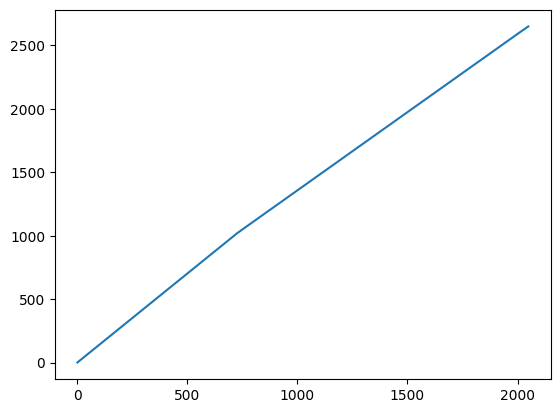

In [23]:
plt.plot((results["flexible_static_Nuke"]["fpd"] * NPP_P_max / NPP_efficiency) / NPP_fuel_weight)